In [11]:
%load_ext autoreload
%autoreload 2

In [12]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl
from pathlib import Path
import torch

from scipy import signal
import ssm

from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter
import pandas as pd
import joblib

from transphorm.preprocessors.loaders import AADataLoader
from transphorm.analyzers import ARHMMAnalyzer
from dotenv import load_dotenv

load_dotenv()


True

In [13]:
data_path = "/Users/mds8301/Desktop/temp/da_full_timeseries_partitioned_learning.pt"

In [14]:
# model_path = Path("/projects/p31961/transphorm/models/arhmm/strange_cat_2082.joblib")
# data_path = Path("/home/mds8301/data/gaby_data/full_recordings/dopamine_full_timeserioes_array.pt")
# model = joblib.load(model_path)
loader = AADataLoader(data_path, down_sample=True, low_pass=True, down_sample_factor=1000)
loader.load_data()
loader.prepare_data()


In [18]:
from sklearn.model_selection import train_test_split
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

x = loader.data[:, 1:][:, ::1000]
y = loader.data[:, 0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x.shape

(88, 1504)

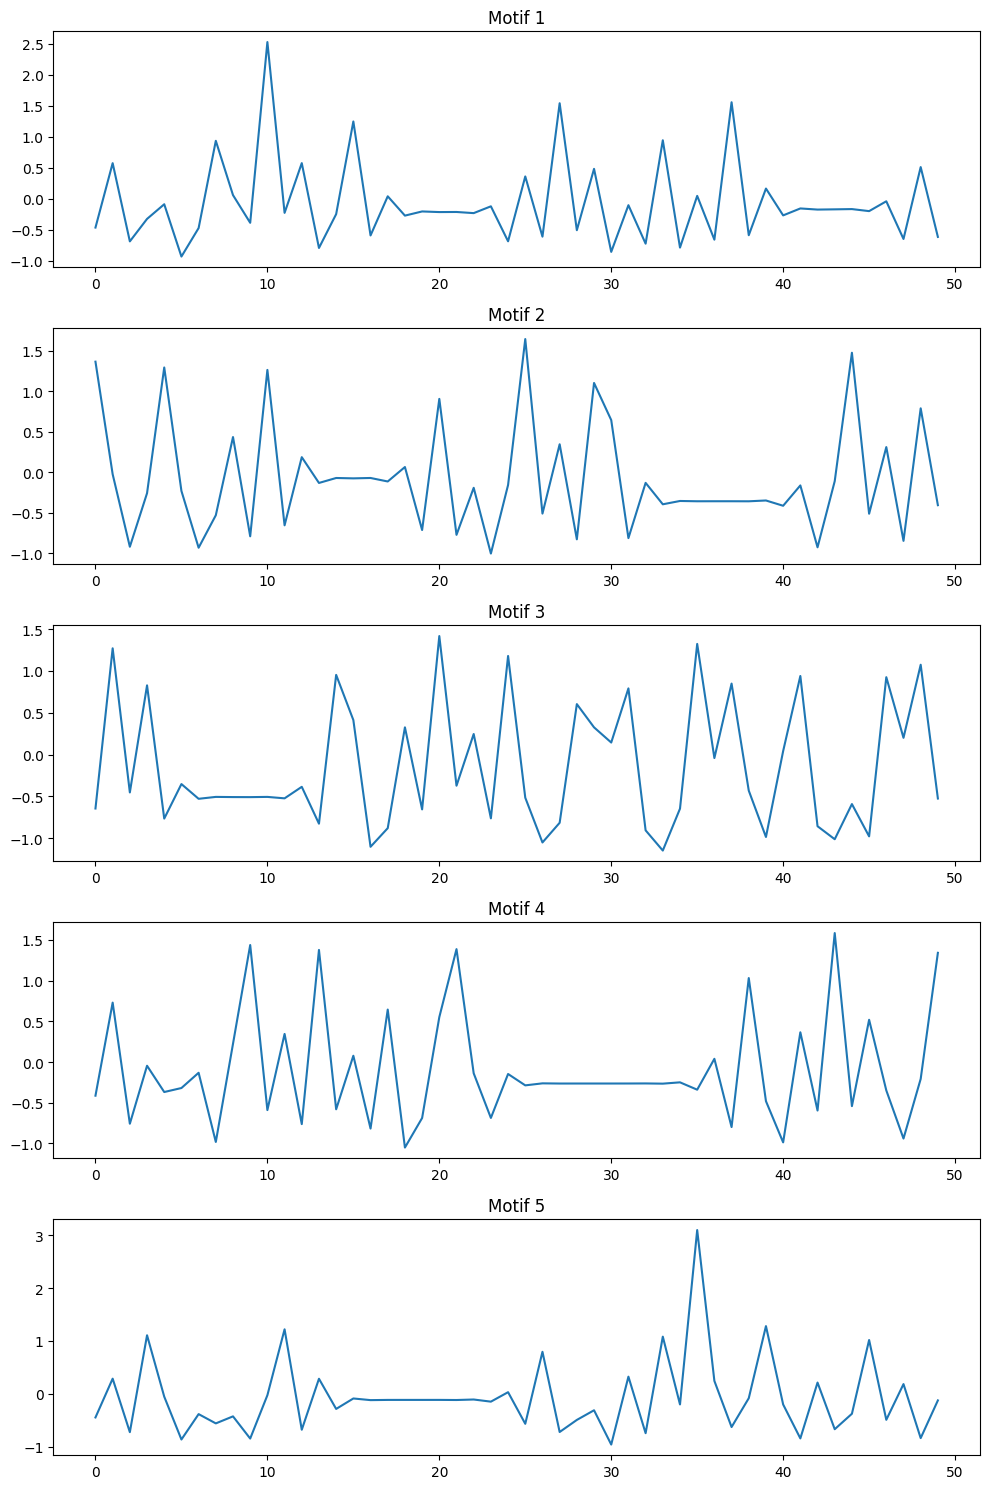

Motif 1 occurs 0 times
Motif 2 occurs 0 times
Motif 3 occurs 0 times
Motif 4 occurs 0 times
Motif 5 occurs 0 times


In [19]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
import matplotlib.pyplot as plt

# 1. Extract subsequences
def extract_subsequences(x, subsequence_length, stride=1):
    if x.ndim == 2:
        n_samples, n_timesteps = x.shape
        n_features = 1
        x = x.reshape(n_samples, n_timesteps, n_features)
    else:
        n_samples, n_timesteps, n_features = x.shape
    
    subsequences = []
    for i in range(n_samples):
        for j in range(0, n_timesteps - subsequence_length + 1, stride):
            subsequences.append(x[i, j:j+subsequence_length, :])
    return np.array(subsequences)

subsequence_length = 50  # Adjust based on expected motif length
stride = 10  # Adjust to control overlap between subsequences
subsequences = extract_subsequences(x_train, subsequence_length, stride)

# 2. Scale the subsequences
scaler = TimeSeriesScalerMeanVariance()
scaled_subsequences = scaler.fit_transform(subsequences)

# 3. Cluster the subsequences
n_clusters = 5  # Adjust based on how many motif types you expect
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_subsequences)

# 4. Identify motifs (cluster centers)
motifs = kmeans.cluster_centers_

# 5. Visualize motifs
fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 3*n_clusters))
for i, motif in enumerate(motifs):
    axes[i].plot(motif.ravel())
    axes[i].set_title(f'Motif {i+1}')
plt.tight_layout()
plt.show()

# 6. Find occurrences of motifs in original data
def find_motif_occurrences(x, motifs, threshold=0.1):
    if x.ndim == 2:
        x = x.reshape(x.shape[0], x.shape[1], 1)
    occurrences = []
    for i, series in enumerate(x):
        for j in range(len(series) - subsequence_length + 1):
            subseries = series[j:j+subsequence_length]
            distances = [np.mean((subseries - motif)**2) for motif in motifs]
            if min(distances) < threshold:
                occurrences.append((i, j, np.argmin(distances)))
    return occurrences

motif_occurrences = find_motif_occurrences(x_train, motifs)

# Print some statistics about motif occurrences
for i in range(n_clusters):
    count = sum(1 for occ in motif_occurrences if occ[2] == i)
    print(f"Motif {i+1} occurs {count} times")

[]